<h3>Forex Prediction Project

<h4>Modelling 2: Gradient Boosting with XGBoost

In [2]:
import pandas as pd
from data_functions import *

In [3]:
data,currency_dict,countries = load_and_process_forex_data()

In [4]:
data.head()

,Date,EURO/US$,UNITED KINGDOM POUND/US$,YEN/US$,YUAN/US$,AUSTRALIAN DOLLAR/US$
0,2000-01-03,0.9847,0.6146,101.70,8.2798,1.5172
1,2000-01-04,0.9700,0.6109,103.09,8.2799,1.5239
2,2000-01-05,0.9676,0.6092,103.77,8.2798,1.5267
3,2000-01-06,0.9686,0.6070,105.19,8.2797,1.5291
4,2000-01-07,0.9714,0.6104,105.17,8.2794,1.5272


In [5]:
currency_dict

{'EURO AREA': 'EURO/US$',
 'UNITED KINGDOM': 'UNITED KINGDOM POUND/US$',
 'JAPAN': 'YEN/US$',
 'CHINA': 'YUAN/US$',
 'AUSTRALIA': 'AUSTRALIAN DOLLAR/US$'}

In [6]:
countries

['EURO AREA', 'UNITED KINGDOM', 'JAPAN', 'CHINA', 'AUSTRALIA']

In [7]:
def extract_currency_data(data, currency):
    """
    Extract a specific country's data from the main dataframe.
    
    Parameters:
    data (DataFrame): The main dataframe containing all countries' data
    country_name (str): The name of the country to extract data for
    
    Returns:
    DataFrame: A dataframe containing only the specified country's data with date column
    """
    country_data = data[['Date',currency]].copy()
    
    # Ensure date column is included and properly formatted
    
    return country_data

In [8]:
# Extract all the currencies from data using extract_currency_data() function in a loop
raw_gradient_data = {}
for country in countries:
    raw_gradient_data[currency_dict[country]] = extract_currency_data(data,currency_dict[country])


In [9]:
# As a function:
def create_data_dict_currency(data,countries,currency_dict):

    data_dict = {}
    for country in countries:
        data_dict[currency_dict[country]] = extract_currency_data(data,currency_dict[country])
    
    return data_dict

<h5>Preparing Data for Gradient Boosting Modelling

In [10]:
# Processing:
# - Create lagging features. LAGS = [1, 2, 3, 5, 10, 20, 30, 60, n], where n is the price n days ago...
# - Create time features (days, weeks, months)
# - Add rolling statistics e.g. rolling averages
# - Add forecasting column (target) (will be 60 in our case)
# - Train-test split (no randomness)

# Take time with this to make sure the data is properly processed, as there are lots of things being added ready for model-input.

In [11]:
# Processing function:
def prepare_single_time_series_indexed_xgboost(
    df: pd.DataFrame,
    currency: str,
    horizon: int = 60, #Test set size (in rows)
    lags: tuple = (1, 2, 3, 5, 7, 14, 21, 28, 35, 42, 49, 56),
    rolling_windows: tuple = (7, 14, 28, 56),
) -> dict:
    """
    Prepare a univariate daily time series for XGBoost training using an index-based approach on a single currency.
    Non-random splitting used

    df = [Date/Index, Price/Currency]
    currency = 'EURO/US$','UNITED KINGDOM POUND/US$' etc
            

    Assumptions:
      - Each row is separated by exactly one day
      - Data is already sorted chronologically
      - Model predicts next-day price (t+1)
      - 60-day forecast achieved via recursive prediction

    Train-test split:
      - Last `horizon` rows used as test set

    Returns:
      dict containing:
        X_train, y_train, X_test, y_test, feature_cols, df_features
    """

    if currency not in df.columns:
        raise ValueError(f"Column '{currency}' not found in dataframe.")

    data = df[[currency]].copy().reset_index(drop=True)

    # Create simple integer time index
    data["t"] = np.arange(len(data))

    # Target: next-day price
    data["y"] = data[currency].shift(-1)

    # Lag features
    for lag in lags:
        data[f"lag_{lag}"] = data[currency].shift(lag)

    # Rolling statistics (past-only)
    shifted = data[currency].shift(1)
    for w in rolling_windows:
        data[f"roll_mean_{w}"] = shifted.rolling(w).mean()
        data[f"roll_std_{w}"]  = shifted.rolling(w).std()
        data[f"roll_min_{w}"]  = shifted.rolling(w).min()
        data[f"roll_max_{w}"]  = shifted.rolling(w).max()

    # Momentum features
    data["diff_1"] = data[currency].diff(1)
    data["pct_change_1"] = data[currency].pct_change(1)

    # Feature columns (exclude raw price + target)
    exclude = {currency, "y"}
    feature_cols = [c for c in data.columns if c not in exclude]

    # Drop rows with NaNs caused by shifting/rolling
    data_model = data.dropna().copy()

    if len(data_model) <= horizon:
        raise ValueError("Not enough data after feature creation for the chosen horizon.")

    # Time-based split (no shuffling)
    train_df = data_model.iloc[:-horizon]
    test_df = data_model.iloc[-horizon:]

    X_train = train_df[feature_cols]
    y_train = train_df["y"]
    X_test = test_df[feature_cols]
    y_test = test_df["y"]

    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "feature_cols": feature_cols,
        "df_features": data_model
    }

In [12]:
# Transform all currency dataframes using prepare_xgb_time_series_indexed
processed_xgb_data = {}

for currency, df in raw_gradient_data.items():
    # Get the currency column name (second column after Date)
    price_col = df.columns[1]
    
    # Apply the XGBoost preparation function
    processed_xgb_data[currency] = prepare_single_time_series_indexed_xgboost(
        df=df,
        currency=price_col,
        horizon=60,
        lags=(1, 2, 3, 5, 7, 14, 21, 28, 35, 42, 49, 56),
        rolling_windows=(7, 14, 28, 56)
    )

In [13]:
# Above cell as a function:
def process_all_xgboost(raw_gradient_data):
    """
    Apply the prepare_single_time_series_indexed_xgboost() function to a dictionary of datframes containing all 
    currencies (created from create_data_dict_currency() function, with structure {currency:df}
    """
    processed_xgb_data = {}

    for currency, df in raw_gradient_data.items():
        # Get the currency column name (second column after Date)
        price_col = df.columns[1]
        
        # Apply the XGBoost preparation function (for a single currency)
        processed_xgb_data[currency] = prepare_single_time_series_indexed_xgboost(
            df=df,
            currency=price_col,
            horizon=60,
            lags=(1, 2, 3, 5, 7, 14, 21, 28, 35, 42, 49, 56),
            rolling_windows=(7, 14, 28, 56)
        )
    
    return processed_xgb_data


In [14]:
processed_xgb_data = process_all_xgboost(raw_gradient_data)

In [15]:
processed_xgb_data['EURO/US$']['X_test'].head()
# Looks good.

,t,lag_1,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,lag_35,...,roll_mean_28,roll_std_28,roll_min_28,roll_max_28,roll_mean_56,roll_std_56,roll_min_56,roll_max_56,diff_1,pct_change_1
4958,4958,0.9147,0.9170,0.9139,0.9133,0.9098,0.9030,0.9117,0.9018,0.8943,...,0.906954,0.004928,0.8970,0.917,0.901321,0.007337,0.8881,0.917,-0.0015,-0.001640
4959,4959,0.9132,0.9147,0.9170,0.9142,0.9092,0.9030,0.9070,0.8970,0.8973,...,0.907361,0.004957,0.8970,0.917,0.901770,0.007281,0.8900,0.917,-0.0034,-0.003723
4960,4960,0.9098,0.9132,0.9147,0.9139,0.9133,0.9086,0.9060,0.8999,0.9004,...,0.907818,0.004539,0.8999,0.917,0.902089,0.007233,0.8900,0.917,0.0014,0.001539
4961,4961,0.9112,0.9098,0.9132,0.9170,0.9142,0.9039,0.9056,0.9014,0.9016,...,0.908221,0.004305,0.9014,0.917,0.902463,0.007152,0.8900,0.917,-0.0008,-0.000878
4962,4962,0.9104,0.9112,0.9098,0.9147,0.9139,0.9041,0.9045,0.9022,0.9012,...,0.908543,0.004109,0.9022,0.917,0.902816,0.007043,0.8900,0.917,0.0029,0.003185


Model Training:

In [16]:
# Declare the model:
from xgboost import XGBRegressor

test_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

In [17]:
currency_dict

{'EURO AREA': 'EURO/US$',
 'UNITED KINGDOM': 'UNITED KINGDOM POUND/US$',
 'JAPAN': 'YEN/US$',
 'CHINA': 'YUAN/US$',
 'AUSTRALIA': 'AUSTRALIAN DOLLAR/US$'}

In [18]:
# Fit the model on the training data
euro_model = test_model.fit(processed_xgb_data['EURO/US$']['X_train'],processed_xgb_data['EURO/US$']['y_train'])

In [19]:
# Make some predictions
euro_model_predictions = euro_model.predict(processed_xgb_data['EURO/US$']['X_test'])

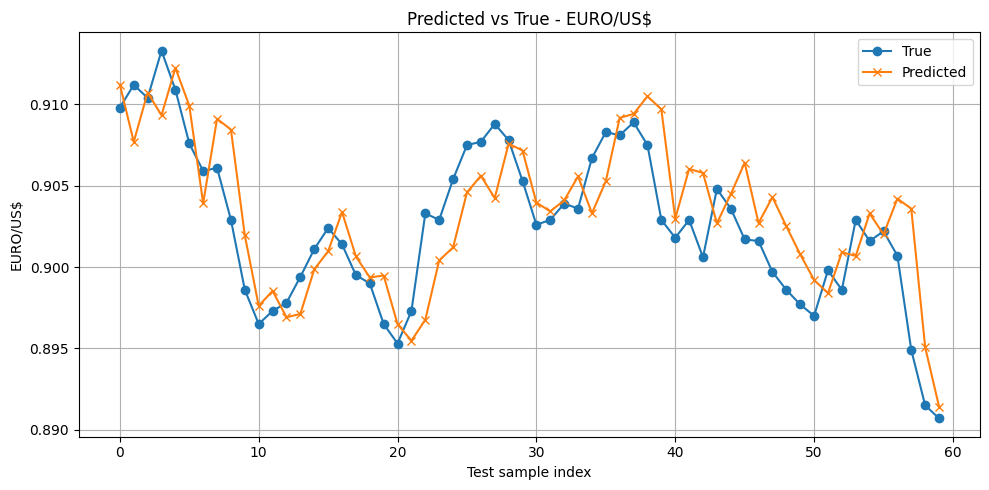

In [20]:
import matplotlib.pyplot as plt


# Plot true vs predicted
plt.figure(figsize=(10, 5))
plt.plot(processed_xgb_data['EURO/US$']['y_test'].reset_index(drop=True), label='True', marker='o')
plt.plot(pd.Series(euro_model_predictions), label='Predicted', marker='x')
plt.xlabel('Test sample index')
plt.ylabel(currency_dict['EURO AREA'])
plt.title(f'Predicted vs True - {currency_dict['EURO AREA']}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# It's a little bit laggy but it looks suprisingly good? 
# There's a 1-2 day lag based on how the feature engineering works. The model is a 1-row ahead prediction model
# 
# X[t] (input features, known) -> y[t+1] (output, predicted, unknown)

In [22]:
processed_xgb_data['EURO/US$']['y_train']

56      1.0284
57      1.0368
58      1.0401
59      1.0500
60      1.0423
         ...  
4953    0.9142
4954    0.9139
4955    0.9170
4956    0.9147
4957    0.9132
Name: y, Length: 4902, dtype: float64

In [23]:
import numpy as np
import pandas as pd

def make_recursive_forecast_xgboost(
    xgb_model,
    df_features: pd.DataFrame,
    currency_col: str,
    feature_cols: list[str],
    forecast_length: int,
    lags: tuple = (1, 2, 3, 5, 7, 14, 21, 28, 35, 42, 49, 56),
    rolling_windows: tuple = (7, 14, 28, 56),
) -> pd.DataFrame:
    """
    True recursive forecaster matching prepare_single_time_series_indexed_xgboost() exactly.

    Inputs
    ------
    df_features:
        Should be the 'df_features' returned by prepare_single_time_series_indexed_xgboost().
        Must contain at least columns: [currency_col, 't', ...features...]
    currency_col:
        The raw price column name used during training (e.g., 'EURO/US$').
    feature_cols:
        The feature column list returned by prepare_single_time_series_indexed_xgboost() (includes 't').
    forecast_length:
        Number of steps to forecast recursively.

    Returns
    -------
    DataFrame indexed by step (1..forecast_length) with forecast_price and (optional) t.
    """

    if forecast_length <= 0:
        raise ValueError("forecast_length must be > 0.")
    if currency_col not in df_features.columns:
        raise ValueError(f"currency_col '{currency_col}' not found in df_features.")
    if any(c not in df_features.columns for c in feature_cols):
        missing = [c for c in feature_cols if c not in df_features.columns]
        raise ValueError(f"feature_cols contain columns not in df_features: {missing}")

    # Work from the end of the feature-engineered dataset
    data = df_features[[currency_col]].copy().reset_index(drop=True)
    data.index.name = "row"

    # We maintain an explicit integer time index 't' just like in your training function
    # Start t from the last known t in df_features (or from len(data)-1 if not present)
    if "t" in df_features.columns:
        last_t = int(df_features["t"].iloc[-1])
    else:
        last_t = len(data) - 1

    def _build_full_feature_frame(price_df: pd.DataFrame, start_t: int) -> pd.DataFrame:
        """Recreate features exactly as in prepare_single_time_series_indexed_xgboost()."""
        df = price_df.copy()
        df["t"] = np.arange(start_t - len(df) + 1, start_t + 1)  # keep 't' consistent/increasing

        # Target (not used for prediction, but keep for parity)
        df["y"] = df[currency_col].shift(-1)

        # Lag features
        for lag in lags:
            df[f"lag_{lag}"] = df[currency_col].shift(lag)

        # Rolling stats (past-only)
        shifted = df[currency_col].shift(1)
        for w in rolling_windows:
            df[f"roll_mean_{w}"] = shifted.rolling(w).mean()
            df[f"roll_std_{w}"]  = shifted.rolling(w).std()
            df[f"roll_min_{w}"]  = shifted.rolling(w).min()
            df[f"roll_max_{w}"]  = shifted.rolling(w).max()

        # Momentum
        df["diff_1"] = df[currency_col].diff(1)
        df["pct_change_1"] = df[currency_col].pct_change(1)

        return df

    forecasts = []
    current_last_t = last_t

    for step in range(1, forecast_length + 1):
        # Build features on the evolving price history
        feat_df = _build_full_feature_frame(data, start_t=current_last_t)

        # Find latest row with complete features (no NaNs in feature_cols)
        valid = feat_df.dropna(subset=feature_cols)
        if valid.empty:
            raise RuntimeError(
                "No valid feature row available (all NaN). "
                "Usually means not enough history for lags/rolls."
            )

        latest = valid.iloc[-1:]
        X_latest = latest[feature_cols]

        # Predict next-day PRICE
        y_hat = float(xgb_model.predict(X_latest)[0])

        # Append predicted price as the next row
        data = pd.concat(
            [data, pd.DataFrame({currency_col: [y_hat]})],
            ignore_index=True
        )

        current_last_t += 1  # advance time index

        forecasts.append({"step": step, "t": current_last_t, "forecast_price": y_hat})

    return pd.DataFrame(forecasts).set_index("step")

In [24]:
bundle = processed_xgb_data['EURO/US$']

forecast_df = make_recursive_forecast_xgboost(
    xgb_model=euro_model,
    df_features=bundle["df_features"],
    currency_col=bundle["df_features"].columns[0],  # or the known currency column name
    feature_cols=bundle["feature_cols"],
    forecast_length=60
)

In [25]:
# Drop the 't' column from forecast_df
forecast_df.drop(columns=['t'], inplace=True, errors='ignore')
forecast_df.head(10)

,forecast_price
step,
1,0.891424
2,0.891669
3,0.891214
4,0.891510
5,0.891166
6,0.891177
7,0.891725
8,0.891714
9,0.891320


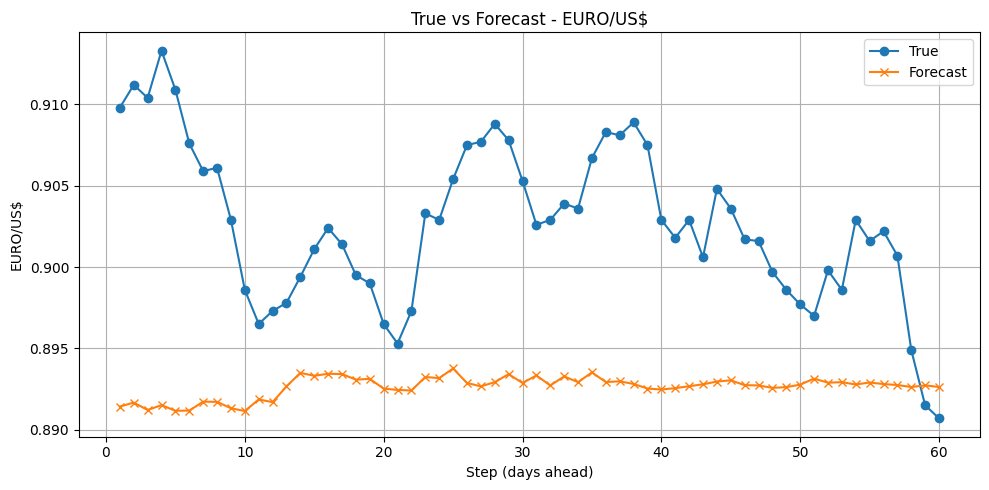

In [26]:
# Plot true vs recursive forecast (aligned by step)
true = bundle['y_test'].reset_index(drop=True)
pred = forecast_df['forecast_price'].reset_index(drop=True)
steps = range(1, len(true) + 1)

plt.figure(figsize=(10, 5))
plt.plot(steps, true, label='True', marker='o')
plt.plot(steps, pred, label='Forecast', marker='x')
plt.xlabel('Step (days ahead)')
plt.ylabel(bundle['df_features'].columns[0])
plt.title(f"True vs Forecast - {bundle['df_features'].columns[0]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Train & forecast for all remaining currencies in processed_xgb_data

models = {"EURO/US$": euro_model}    # keep already-trained euro_model
forecasts = {"EURO/US$": forecast_df}  # keep already-created euro forecast

for currency, bundle in processed_xgb_data.items():
    if currency == "EURO/US$":
        continue

    print(f"Training & forecasting {currency}...")
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror"
    )
    model.fit(bundle["X_train"], bundle["y_train"])
    models[currency] = model

    fc = make_recursive_forecast_xgboost(
        xgb_model=model,
        df_features=bundle["df_features"],
        currency_col=bundle["df_features"].columns[0],
        feature_cols=bundle["feature_cols"],
        forecast_length=len(bundle["y_test"])
    )
    fc.drop(columns=["t"], inplace=True, errors="ignore")
    forecasts[currency] = fc

print("All currencies processed.")

Training & forecasting UNITED KINGDOM POUND/US$...
Training & forecasting YEN/US$...
Training & forecasting YUAN/US$...
Training & forecasting AUSTRALIAN DOLLAR/US$...
All currencies processed.


In [29]:
import pickle
import os

def save_trained_xgb_models(trained_models_dict, save_directory="models"):
    """
    Save trained XGBoost models to pickle files.
    
    Parameters:
    -----------
    trained_models_dict : dict
        Dictionary containing trained models with currency names as keys
    save_directory : str, default="models"
        Directory to save the model files
    
    Returns:
    --------
    dict: Dictionary mapping currency names to their saved file paths
    """
    
    # Create directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    saved_files = {}
    
    for currency_name, model in trained_models_dict.items():
        # Clean currency name for filename (replace special characters)
        clean_name = currency_name.replace("/", "_").replace("$", "").replace(" ", "_")
        filename = f"{clean_name}_xgboost_model.pkl"
        filepath = os.path.join(save_directory, filename)
        
        # Save model using pickle
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        
        saved_files[currency_name] = filepath
        print(f"Saved {currency_name} model to {filepath}")
    
    return saved_files

In [30]:
xgb_models_saved = save_trained_xgb_models(models,"models")

Saved EURO/US$ model to models\EURO_US_xgboost_model.pkl
Saved UNITED KINGDOM POUND/US$ model to models\UNITED_KINGDOM_POUND_US_xgboost_model.pkl
Saved YEN/US$ model to models\YEN_US_xgboost_model.pkl
Saved YUAN/US$ model to models\YUAN_US_xgboost_model.pkl
Saved AUSTRALIAN DOLLAR/US$ model to models\AUSTRALIAN_DOLLAR_US_xgboost_model.pkl


In [31]:
xgb_models_saved

{'EURO/US$': 'models\\EURO_US_xgboost_model.pkl',
 'UNITED KINGDOM POUND/US$': 'models\\UNITED_KINGDOM_POUND_US_xgboost_model.pkl',
 'YEN/US$': 'models\\YEN_US_xgboost_model.pkl',
 'YUAN/US$': 'models\\YUAN_US_xgboost_model.pkl',
 'AUSTRALIAN DOLLAR/US$': 'models\\AUSTRALIAN_DOLLAR_US_xgboost_model.pkl'}